In [33]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
df = pd.read_excel("Online_Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [34]:
import seaborn as sns
sns.set_palette("husl")
sns.set(rc={'image.cmap': 'coolwarm'})
%matplotlib inline

In [35]:
import datetime as dt
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate']).dt.date
df = df[pd.notnull(df['CustomerID'])]
df = df[(df['Quantity']>0)]
df['Sales'] = df['Quantity'] * df['UnitPrice']
cols_of_interest = ['CustomerID', 'InvoiceDate', 'Sales']
df = df[cols_of_interest]
print(df.head())
print(df.head())
print(df['CustomerID'].nunique())

   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
   CustomerID InvoiceDate  Sales
0     17850.0  2010-12-01  15.30
1     17850.0  2010-12-01  20.34
2     17850.0  2010-12-01  22.00
3     17850.0  2010-12-01  20.34
4     17850.0  2010-12-01  20.34
4339


In [36]:
from lifetimes.plotting import *
from lifetimes.utils import *

data = summary_data_from_transaction_data(df, 'CustomerID', 'InvoiceDate', monetary_value_col='Sales', observation_period_end='2011-12-9')
data.head()

,frequency,recency,T,monetary_value
CustomerID,,,,
12346.0,0.0,0.0,325.0,0.000000
12347.0,6.0,365.0,367.0,599.701667
12348.0,3.0,283.0,358.0,301.480000
12349.0,0.0,0.0,18.0,0.000000
12350.0,0.0,0.0,310.0,0.000000


count    4339.000000
mean        2.864024
std         5.952745
min         0.000000
25%         0.000000
50%         1.000000
75%         3.000000
max       131.000000
Name: frequency, dtype: float64
0.3569946992394561


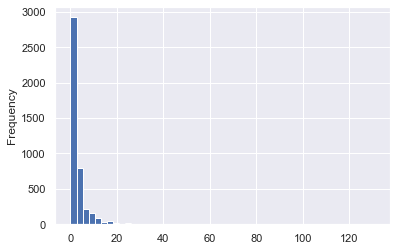

In [37]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print(sum(data['frequency'] == 0)/float(len(data)))

In [41]:
from lifetimes import BetaGeoFitter
bgf = BetaGeoFitter(penalizer_coef=0.0)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 4339 subjects, a: 0.00, alpha: 68.89, b: 6.75, r: 0.83>


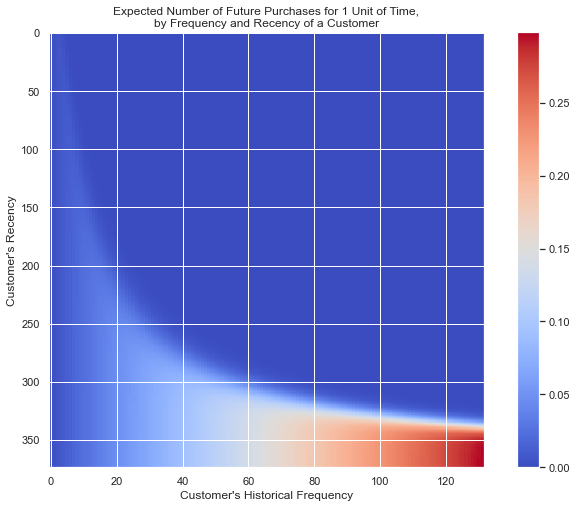

In [42]:
from lifetimes.plotting import plot_frequency_recency_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

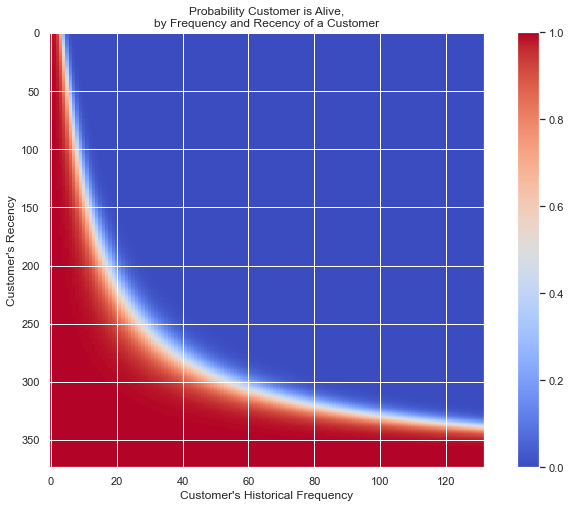

In [43]:
from lifetimes.plotting import plot_probability_alive_matrix
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

In [28]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
CustomerID,,,,,
14606.0,88.0,372.0,373.0,135.890114,0.221330
15311.0,89.0,373.0,373.0,677.729438,0.223836
17841.0,111.0,372.0,373.0,364.452162,0.278962
12748.0,113.0,373.0,373.0,298.360885,0.283973
14911.0,131.0,372.0,373.0,1093.661679,0.329076


In [19]:
from lifetimes.utils import calibration_and_holdout_data
summary_cal_holdout = calibration_and_holdout_data(df, 'CustomerID', 'InvoiceDate',
                                        calibration_period_end='2011-06-08',
                                        observation_period_end='2011-12-9' )   
print(summary_cal_holdout.head())

            frequency_cal  recency_cal  T_cal  frequency_holdout  \
CustomerID                                                         
12346.0               0.0          0.0  141.0                0.0   
12347.0               2.0        121.0  183.0                4.0   
12348.0               2.0        110.0  174.0                1.0   
12350.0               0.0          0.0  126.0                0.0   
12352.0               3.0         34.0  112.0                3.0   

            duration_holdout  
CustomerID                    
12346.0                184.0  
12347.0                184.0  
12348.0                184.0  
12350.0                184.0  
12352.0                184.0  


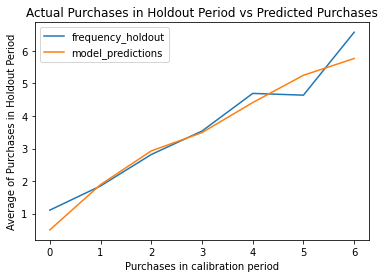

In [20]:
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [21]:
t = 10
individual = data.loc[12347]
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

0.16102733519287163

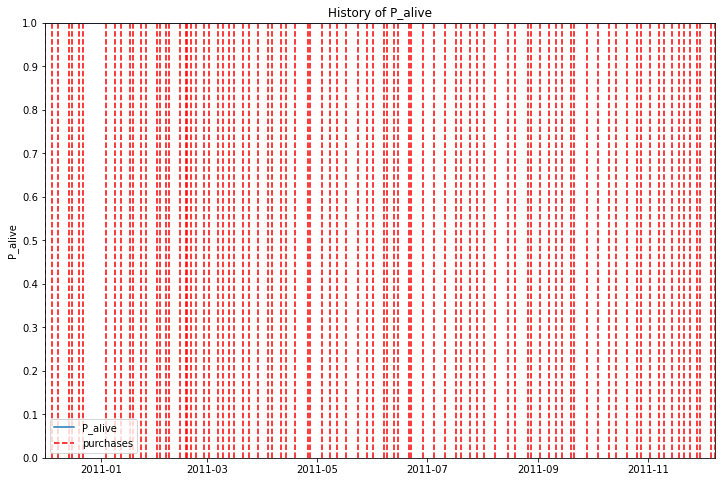

In [22]:
from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = 14606
days_since_birth = 365
sp_trans = df.loc[df['CustomerID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'InvoiceDate')

In [24]:
returning_customers_summary = data[data['frequency']>0]
print(returning_customers_summary.head())
print(len(returning_customers_summary))

            frequency  recency      T  monetary_value  predicted_purchases
CustomerID                                                                
12347.0           6.0    365.0  367.0      599.701667             0.160064
12348.0           3.0    283.0  358.0      301.480000             0.086933
12352.0           6.0    260.0  296.0      368.256667             0.194656
12356.0           2.0    303.0  325.0      269.905000             0.066987
12358.0           1.0    149.0  150.0      683.200000             0.076426
2790


In [25]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'],
        returning_customers_summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2790 subjects, p: 2.10, q: 3.45, v: 485.57>


In [26]:
print(ggf.conditional_expected_average_profit(
        data['frequency'],
        data['monetary_value']
    ).head(10))

CustomerID
12346.0    416.917667
12347.0    569.988807
12348.0    333.762672
12349.0    416.917667
12350.0    416.917667
12352.0    376.166864
12353.0    416.917667
12354.0    416.917667
12355.0    416.917667
12356.0    324.008941
dtype: float64
